# Dynamic linear models

In [1]:
import numpy as np
from numpy import linalg as la
from tabulate import tabulate 
import pandas as pd 
import LinearDynamic as lm
import seaborn as sns
sns.set_theme(); 

np.set_printoptions(precision=5)
%load_ext autoreload
%autoreload 2

# Prepare the data

In this problem set, we consider the question of state dependence in **firm revenue** ($y$). The data, `cvr_extract.csv`, comes from the Danish register of firms, "CVR registret". It can be reconstructed or modified by downloading the tax files from [skst.dk](https://www.sktst.dk/aktuelt/skatteoplysninger-for-selskaber/) and running the notebook `clean_data.ipynb`. 

The data consists of all firms observed in every year from 2012-2019, which satisfy that the net income (pre-tax) was below 10 mio. DKK. The variables in the data are: 

  |*Variable*  | *Content* |
  |------------| --------------------------------------------|
  |`net_inc`          | Net income (`income - deficit`) |
  |`taxable_income`          | Income |
  |`deficit`          | Losses |
  |`tax`          | Tax payment |
 | `cat`         | A categorical variable, based on the dummies, `dum_X` below |
  | `dum_X`          | Dummy for whether the firm's name contains the string `X` (in Danish) |
  
  The dummies, e.g. `dum_doctor`, are explained below 

| **Substring** | **If name contains** | 
| ---- | ------ | 
| `as` | 'a/s' | 
| `aps` | 'aps' | 
| `ivs` | 'ivs' | 
| `ab` | 'a/b' | 
| `realestate` | 'ejendom' | 
| `holding` | 'holding' | 
| `invest` | 'invest' | 
| `consult` | 'consult' | 
| `service` | 'service' | 
| `dot_dk` | '.dk' | 
| `doctor` | 'læge' | 
| `carpenter` | 'tømrer' | 
| `transport` | 'transport' or 'lastvogn' | 
| `plumbing` | 'vvs' or 'kloak' | 
| `import` | 'import' | 
| `masonry` | 'murer' | 
| `nielsen` | 'nielsen' | 
| `sorensen` | 'sørensen' | 

In [2]:
dat = pd.read_csv('cvr_extract.csv')
dat.sample(3)

,firmid,year,taxable_income,deficit,tax,net_inc,cat,dum_as,dum_aps,dum_ivs,...,dum_dot_dk,dum_doctor,dum_carpenter,dum_transport,dum_plumbing,dum_import,dum_masonry,dum_nielsen,dum_sorensen,dum_cars
219046,27380,2018,-1450.0,0.0,0.0,-1450.0,holding,0,1,0,...,0,0,0,0,0,0,0,0,0,0
474111,59263,2019,-4848178.0,0.0,0.0,-4848178.0,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
187745,23468,2013,0.0,114138.0,0.0,-114138.0,NaN,0,1,0,...,0,0,0,0,0,0,0,0,0,0


# Descriptives

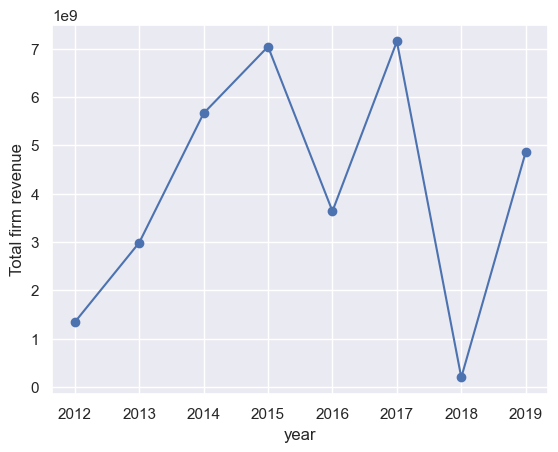

In [3]:
ax=dat.groupby('year').net_inc.sum().plot(marker='o'); 
ax.set_ylabel('Total firm revenue'); 

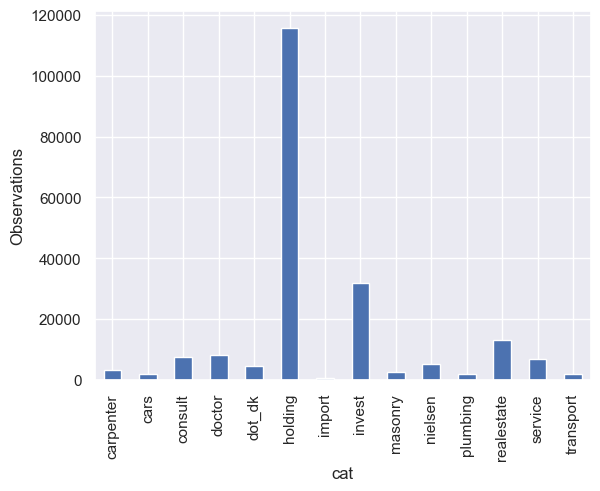

In [4]:
ax = dat.groupby('cat').taxable_income.count().plot(kind='bar'); 
ax.set_ylabel('Observations'); 

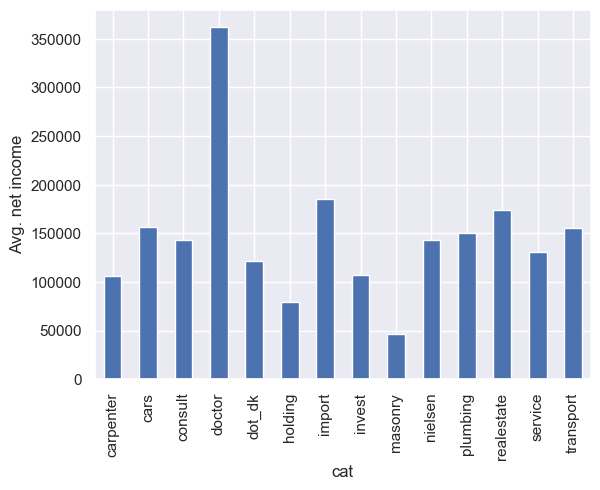

In [5]:
ax = dat.groupby('cat').taxable_income.mean().plot(kind='bar'); 
ax.set_ylabel('Avg. net income'); 

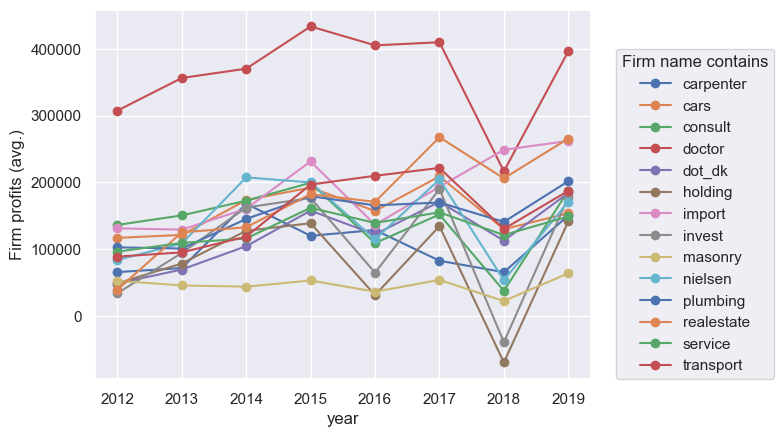

In [6]:
ax=dat.groupby(['year', 'cat']).taxable_income.mean().unstack().plot(marker='o'); 
ax.set_ylabel('Firm profits (avg.)'); 
ax.legend(title='Firm name contains', loc=(1.05,0.)); 

# Set up data

In [7]:
# # select only firms that are in transport in all years 
# I = dat.groupby('firmid').dum_realestate.transform('all')
# dat = dat[I].copy()

In [8]:
# convenient list of the names of all the dummy variables
cols_dum = [c for c in dat.columns if c == 'dum_']

# convert int->bool 
for c in cols_dum: 
    dat[c] = dat[c].astype('bool')

N = dat.firmid.unique().size
T = dat.year.unique().size
print(f'Data has {dat.shape[0]:,d} rows: N = {N:,d}, T = {T}')

Data has 519,416 rows: N = 64,927, T = 8


In [9]:
# measure money in 1000 DKK 
for v in ['net_inc', 'taxable_income', 'deficit', 'tax']: 
    dat[v] = dat[v] / 1000.

In [10]:
dat['lag_net_inc'] = dat.groupby('firmid').net_inc.shift(1)

### Pandas to numpy 

In [11]:
I = dat.lag_net_inc.notnull() # cannot use first year: no lagged variable 
T = dat[I].year.unique().size
N = dat[I].firmid.unique().size

assert dat[I].shape[0] == N*T, 'Data is not a balanced panel'

In [12]:
y = dat[I].net_inc.values.reshape((-1,1))
y_l = dat[I].lag_net_inc.values.reshape((-1,1))
const = np.ones((N*T,1))
x = np.column_stack((const, y_l))

ylbl = 'profit'
xlbl = ['const', 'lagged profit']

# Part 1: POLS
Today we will focus on a parsimonious model of profit $\pi (econometricians often use "parsimonious" to mean a "simple"). 

Consider first the following AR(1) (autoregressive model of order $1$),

$$
\pi_{it} = \alpha_0 +  \rho \pi_{it-1} + c_i + u_{it}, \quad t = 1, 2, \dotsc, T \tag{1}
$$

As we have seen before, if one does not take into consideration $c_i$ when estimating $\rho$, one will get biased results. One way to solve this, which is also a common way for AR(1) processes, is to take first-differences. We then have the model,

$$
\Delta \pi_{it} = \rho \Delta \pi_{it-1} + \Delta u_{it}, \quad t = 2, \dotsc, T \tag{2}
$$

This solves the presence of fixed effects.

### Question 1
Estimate eq. (1) using POLS. 
* Are there signs of autocorrelation in profit?
* What assumptions are no longer satisfied? What happens with fixed effects when we include a lag?

*Note:* We need to use the lagged values for participation. But this time we don't need to lag it ourselves, as it is already given to us in the data.

In [13]:
# FILL IN
# Estimate the AR(1) model using OLS
# Print out in a nice table

In [14]:
print(x.shape)
print(y.shape)

ar1_result = lm.estimate(y, x, robust_se=True, T=T)
lm.print_table(
    (ylbl, xlbl), ar1_result, title='AR(1)', floatfmt=['', '.3f', '.5f', '.2f']
)

(454489, 2)
(454489, 1)
AR(1)
Dependent variable: profit

                 Beta       Se    t-values
-------------  ------  -------  ----------
const          33.037  0.98750       33.46
lagged profit   0.589  0.00629       93.75
R² = 0.328
σ² = 402764.374


Your table should look like this:


AR(1)
Dependent variable: profit

|              |  Beta |     Se|   t-values | 
|------------- | ------|  -------|  ----------|
|const   |       33.037 | 0.98750 |      33.46|
|lagged profit |  0.589 | 0.00629  |     93.75| 
R² = 0.328
σ² = 402764.374

In [15]:
pd.DataFrame([ar1_result['b_hat'].flatten(), ar1_result['se'].flatten(),ar1_result['t_values'].flatten()], 
             index=['beta', 'se', 't'], columns=xlbl).T

,beta,se,t
const,33.03679,0.987498,33.455055
lagged profit,0.58945,0.006287,93.750146


### Question 2
Estimate eq. (2) using first differences. 
* What problem does this solve? 
* What type of exogeneity assumption is used to justify this method of estimation?

*Note:* You have to create the first differencing matrix yourself, and use the `perm` function to permutate the dependen and independent variables. <br>
*Note 2:* This time you should use robust standard errors. The function is provided to you.

In [16]:
# FILL IN
# Create a first difference matrix
# First difference both pi and lag of pi
# Estimate AR(1) model using OLS and print a nice table

In [17]:
def fd(t):
    # Create a first difference matrix.
    # We also remove the last row, so that we delete the first observation.
    D_t = np.eye(t, k=1) - np.eye(t)
    return D_t[:-1]

In [18]:
D_t = fd(T)
yfd = lm.perm(D_t, y)
yfd_l = lm.perm(D_t, y_l.reshape(-1, 1))

In [19]:
ar1_diff_result = lm.estimate(yfd, yfd_l, robust_se=True, T=T-1, transform='fd')
lm.print_table(
    (ylbl, [xlbl[1]]), 
    ar1_diff_result, title='FD AR(1)', floatfmt=['', '.3f', '.4f', '.2f']
)

FD AR(1)
Dependent variable: profit

                 Beta      Se    t-values
-------------  ------  ------  ----------
lagged profit  -0.410  0.0056      -73.13
R² = 0.160
σ² = 427320.714


Your table should look like this:

FD AR(1) <br>
Dependent variable: profit

|              |   Beta |     Se |   t-values |
|------------- | ------ | ------ | ---------- |
|lagged profit | -0.410 | 0.0056 |     -73.13 |
R² = 0.160
σ² = 427320.714

## Super short introduction to pooled IV (piv)

Consider that we want to estimate the effect of $x_K$ on $y$, including $K - 1$ controls, we then have the usual equation,

$$
\mathbf{y} = \mathbf{X} \boldsymbol{\beta} + \mathbf{u} \tag{3}
$$

where $\mathbf{X} = (\mathbf{x}_1, \dotsc, \mathbf{x}_K)$. If $\mathbf{x}_K$ is not exogenous, we can define the instrument vector $\mathbf{Z} = (\mathbf{x}_1, \dotsc, \mathbf{x}_{K - 1}, \mathbf{z}_1)$, where $\mathbf{z}_1$ is an instrument for $\mathbf{x}_K$. The details and necessary assumptions and conditions are outlined in Wooldridge (2010) (chapter 5).

We can estimate eq. (1) by OLS using $z_1$ as an instrument for $x_K$, in order to make it easier for you when writing code, I write it up in matrix notation,

$$
\boldsymbol{\hat{\beta}} = (\mathbf{\hat{X'}}\mathbf{\hat{X}})^{-1} \mathbf{\hat{X'}}\mathbf{Y}, \tag{4}
$$

where $\mathbf{\hat{X}} = \mathbf{Z}(\mathbf{Z'}\mathbf{Z})^{-1}\mathbf{Z'}\mathbf{X}$.

# Part 2: Pooled IV
It should not be a surprise that models (1) and (2) violates the strict exegoneity assumption, but even if we relax this assumption to sequential exegoneity, the FD-estimator remains inconsistent.

A solution for this is to use an instrument for $\Delta \pi_{it-1}$. The biggest issue is to find an instrument that is not only relevant, but also exogenous.

We often use an additional lag as instruments. So for $\Delta \pi_{it-1}$, we can use $\pi_{it-2}$. In general, we have all possible lags available as instruments. So for $\Delta \pi_{it-1}$ we have, $
\pi_{it-2}^{\textbf{o}} = (\pi_{i0}, \pi_{i1}, \dotsc \pi_{it-2})$ available as instruments.

*Note:* $R^2$ has no meaning in IV-regressions, you can report it if you want to. But I set it to 0.

### Question 1
Estimate eq. (2) by using the lag of the independent variable in levels, $z_{it} = \pi_{it-2}$ as an instrument. You need to finish writing the `est_piv` function and a part of the `estimate` function.

*Note:* In the estimate function, the variance function takes x as an argument. But we want to pass the `variance` function $\mathbf{\hat{X}}$ instead. <br>
*Note 2:* In order to create the instrument, you need to create a lag matrix, and use `perm`.

In [20]:
# FILL IN
# Create first a lag matrix
# Lag the lagged pi variable
# Finish writing the piv function
# Finish writing the estimate function
# Estimate using first differences and lagged first differences. Use the 2. lag as instrument.

In [21]:
def lag(t):
    # Create a lag matrix.
    # Again remove the first observation, by removing the first row.
    L_t = np.eye(t, k=-1)
    return L_t[1:]

In [22]:
# First lag yl, and then use it as an instrument for the lagged differences.
L_t = lag(T)
y_2l = lm.perm(L_t, y_l.reshape(-1, 1))


The code below takes ages to run on the full sample. 

In [23]:
ar1_iv_lvl_result = lm.estimate(yfd, yfd_l, y_2l, robust_se=True, T=T-1)

lm.print_table(
    (ylbl, [xlbl[1]]), 
    ar1_iv_lvl_result, title='FD-IV AR(1)', floatfmt=['', '.3f', '.4f', '.2f']
)

FD-IV AR(1)
Dependent variable: profit

                 Beta      Se    t-values
-------------  ------  ------  ----------
lagged profit   0.153  0.0112       13.63
R² = nan
σ² = 580426.756


Your table should look like this:

FD-IV AR(1) <br>
Dependent variable: delta profit

|                   |   Beta |     Se |   t-values |
|-------------------|--------|--------|------------|
| lagged profit     |  0.153 |  0.0112|      13.63 | 
R² = n.a. <br>
σ² = 580426.756

### Question 2
Estimate eq. (2) by using the lag of the independent variable in first differences, $z_{it} = \Delta \pi_{it-2}$ as an instrument.

In [24]:
# FILL IN
# Lag the first differenced lag pi variable
# The second lag uses up an extra observation, so you need to use the year variable to shorten both first differenced pi and the 1. first difference lag.
# Estimate using first differences and lagged first differences. Use the 2. first difference lag as instrument.

In [25]:
# Create a new lag matrix (that is shorter, since we already removed one obs)
# Create second lag of first differences.
L_t = lag(T - 1)
yfd_l2 = lm.perm(L_t, yfd_l)

In [26]:
dat['diff_net_inc']      = dat.groupby('firmid').net_inc.diff()
dat['lag_diff_net_inc']  = dat.groupby('firmid').diff_net_inc.shift(1)
dat['lag2_diff_net_inc'] = dat.groupby('firmid').diff_net_inc.shift(2)

In [27]:
assert dat.shape[0] == (dat.year.unique().size * dat.firmid.unique().size), 'Not balanced'

In [28]:
I = dat.lag2_diff_net_inc.notnull()
yfd    = dat[I].diff_net_inc.values.reshape((-1,1))
yfd_l1 = dat[I].lag_diff_net_inc.values.reshape((-1,1))
yfd_l2 = dat[I].lag2_diff_net_inc.values.reshape((-1,1))

assert (dat.groupby('firmid').year.size() == dat.year.unique().size).all(), 'not balanced'

In [29]:
assert not np.isnan(yfd_l2).any(), 'Something went wrong above...'

In [30]:
# # Remove the first observation for each person.
# reduced_year = year[year != 1986]  # Remove first year, so that shape is the same as yfd
# yfd0 = yfd[reduced_year != 1987]
# yfd_l0 = yfd_l[reduced_year != 1987]

In [31]:
ar1_iv_result = lm.estimate(
    yfd, yfd_l1, yfd_l2, robust_se=True, T=T-2
)
lm.print_table(
    (ylbl, ['delta lag y_t']), 
    ar1_iv_result, title='FD-IV AR(1)', floatfmt=['', '.3f', '.4f', '.2f']
)

FD-IV AR(1)
Dependent variable: profit

                 Beta      Se    t-values
-------------  ------  ------  ----------
delta lag y_t  -0.005  0.0193       -0.28
R² = nan
σ² = 529085.073


Your table should look like this:
FD-IV AR(1) <br>
Dependent variable: delta profit

|                   |   Beta |     Se |   t-values |
|-------------------|--------|--------|------------|
| lag delta profit|  -0.005 | 0.0193 |       -0.28 |
R² = n.a <br>
σ² = 529085.073

### Summing up Exercise 1 and 2.

First of all, try to consider if it is more obvious to use $\pi_{it-2}$ or $\Delta \pi_{it-2}$ as an instrument for $\Delta \pi_{it-1}$?

Then consider how do the different models compare to each other, some questions that you might discuss with your class mates could be:
* Which ones do you feel gives most sense from an economic perspective. 
* Which ones gives most sense from an econometric perspective? 
* Do you feel that there is conclusive evidence that there is state dependence in female labour market participation?

### Question 1: Create the level instrument matrix $\mathbf{Z^{\mathbf{o}}}$

Finish the function `sequential_instruments` in order to create the instrument matrix $\mathbf{Z^{\mathbf{o}}}$ using the second lag of $\pi$ in **levels**. Note that you will not have one array that looks like $\mathbf{Z^{\mathbf{o}}}$, but an array that have something that looks like $\mathbf{Z^{\mathbf{o}}}$ for each individual in the data. Since we have four time periods, and access to $y_{i0}$, you should get three rows of instruments for each individual.
$$
\mathbf{Z^{\mathbf{o}}} = 
\begin{bmatrix}
    y_{i0} & 0 & 0 & 0 & 0 & 0 & \cdots & 0 \\
    0 & y_{i0} & y_{i1} & 0 & 0 & 0 & \cdots & 0 \\
    0 & 0 & 0 & y_{i0} & y_{i1} & y_{i2} & \cdots & 0 \\
    \vdots  & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & 0 & 0 & 0 & 0 & \cdots & \mathbf{y^o_{it-2}} \\
\end{bmatrix}
\begin{pmatrix}
t = 2 \\
t = 3 \\
t = 3 \\
\vdots \\
t = T
\end{pmatrix}.
$$

If if is too difficult to create the instrument matrix $\mathbf{Z^{\mathbf{o}}}$, you could also in this instance hard code it. This can be done by using the year column to do boolean indexing in python. You can then use the `np.hstack` to create the necessary columns for the first stage regressions. Look at *question 2* below if you are uncertain on how many columns you should have for each regression.

In [32]:
import gmm_post as gmm 

In [33]:
instrument_matrix = gmm.sequential_instruments(y_2l, T)
print(instrument_matrix)

[[129.782   0.      0.    ...   0.      0.      0.   ]
 [  0.    129.782  80.308 ...   0.      0.      0.   ]
 [  0.      0.      0.    ...   0.      0.      0.   ]
 ...
 [  0.      0.      0.    ...   0.      0.      0.   ]
 [  0.      0.      0.    ...   0.      0.      0.   ]
 [  0.      0.      0.    ... -56.367 -63.176 -17.747]]


To prepeare for next question, I have created an function that retrieves one time period for each person, and store them in seperate arrays, and finaly returns these in a list. (I also keep the array for the all time periods, since we need that for the second stage regression). 

In [34]:
def xy_eq_by_eq(x, t):
    equation = []
    # Reshape, so that each column is each time period
    xt = x.reshape(-1, t)

    # I then transpose this, so that each time period is in rows
    for row in xt.T:
        # I then put each time period in a separate array, that I store in the list.
        equation.append(row.reshape(-1, 1))
    # We need individual observations for all years in the second stage regression,
    # so let us keep that at the end of the list.
    equation.append(x)
    return equation

In [35]:
# reset: now we no longer need to delete *3* years but only 2. 
I = dat.lag_diff_net_inc.notnull()
yfd    = dat[I].diff_net_inc.values.reshape((-1,1))
yfd_l  = dat[I].lag_diff_net_inc.values.reshape((-1,1))
years  = dat[I].year.values
print(yfd)

[[ 99.427]
 [-83.545]
 [ -8.617]
 ...
 [ 45.429]
 [ 14.518]
 [-98.441]]


In [36]:
y_arrays = xy_eq_by_eq(yfd, T-1)
x_arrays = xy_eq_by_eq(yfd_l, T-1)
print(y_arrays)

[array([[ 99.427],
       [ 47.674],
       [-14.824],
       ...,
       [ 12.67 ],
       [  0.   ],
       [ 25.723]]), array([[-83.545],
       [-49.08 ],
       [ -7.966],
       ...,
       [-34.419],
       [  0.   ],
       [-42.392]]), array([[ -8.617],
       [-50.306],
       [-92.95 ],
       ...,
       [ 34.419],
       [  0.   ],
       [ -6.809]]), array([[-88.356],
       [-46.856],
       [ 45.939],
       ...,
       [-15.07 ],
       [  0.   ],
       [ 45.429]]), array([[   8.572],
       [-426.98 ],
       [ -72.057],
       ...,
       [ -80.442],
       [   0.   ],
       [  14.518]]), array([[-37.086],
       [532.894],
       [-17.551],
       ...,
       [ 38.273],
       [  0.   ],
       [-98.441]]), array([[ 99.427],
       [-83.545],
       [ -8.617],
       ...,
       [ 45.429],
       [ 14.518],
       [-98.441]])]


### Question 2: Use the instruments to perform 2SLS

Now that you have the necessary instruments, use these to estimate eq. (2), with all possible lagged levels as instruments.

I recommend that you create two functions for this. One that simply performs the first-stage regression given y and x, let's call it `first_stage`, and should return the predicted $\hat{\mathbf{x}}_K$, which in this case is the second lagged \pi.

The second function, let us call is `system_2sls`, loops over a list of y, x and z arrays that are given as inputs, and performs the `first_stage` regression on each array (remember, each array has all observations from one time period only). Since the `first_stage` function you made returns the predicted $\hat{\mathbf{x}}_K$, you need to keep them, and in the end combine them. You can now perform the second-stage regression.

So in our example where we use levels, you should perform three first-stage regressions that look like this:

$$
\begin{align}
\Delta \pi_{i1987} & = \rho_{11}\pi_{i1986} + u_{it} \\
\Delta \pi_{i1988} & = \rho_{21}\pi_{i1986} + \rho_{22}\pi_{i1987} + u_{it} \\
\Delta \pi_{i1989} & = \rho_{31}\pi_{i1986} + \rho_{32}\pi_{i1987} + \rho_{33}\pi_{i1988} + u_{it} \\
\end{align}
$$

Then, for each regression, you also need to predict the \pi. These need to be stored and in the end combined, so that you get a column that looks like this,

$$
\underset{N(T - 1) \times 1}{
\begin{pmatrix}
    \Delta \widehat{\pi}_{1, 1987} \\
    \Delta \widehat{\pi}_{1, 1988} \\
    \Delta \widehat{\pi}_{1, 1989} \\
    \Delta \widehat{\pi}_{2, 1987} \\
    \Delta \widehat{\pi}_{2, 1988} \\
    \Delta \widehat{\pi}_{2, 1989} \\
    \vdots \\
    \Delta \widehat{\pi}_{N, 1987} \\
    \Delta \widehat{\pi}_{N, 1988} \\
    \Delta \widehat{\pi}_{N, 1989} \\
\end{pmatrix}
}
$$

So in the end, you perform a second stage regression that looks like this

$$
    \Delta \pi_{it} = \rho\Delta \widehat{\pi}_{it-1} + \Delta u_{it}
$$

In [37]:
# I have created these helper functions. So if you managed to create the instrument matrix, 
# you can use the iv_eq_by_eq to get columns that give you the correct number of columns for 
# the different time periods.

In [38]:
instrument_matrix

array([[129.782,   0.   ,   0.   , ...,   0.   ,   0.   ,   0.   ],
       [  0.   , 129.782,  80.308, ...,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   , ...,   0.   ,   0.   ,   0.   ],
       ...,
       [  0.   ,   0.   ,   0.   , ...,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   , ...,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   , ..., -56.367, -63.176, -17.747]])

In [39]:
def IV_eq_by_eq(instrument_matrix, years):
    yy = np.unique(years)
    
    # initialize 
    zz = []
    this_row = 0 
    
    for t,y in enumerate(yy): 
        # the columns for this year 
        ii = slice(this_row, this_row+(t+1))
        z = instrument_matrix[years == y, ii]
        
        # ensure matrix-form 
        if z.ndim == 1: 
            z.reshape(-1,1)
        
        # store results 
        zz.append(z)
    
        # how many rows we skipped this time (1, 2, 3, ...) -> this_row = (0, 1, 3, ..., 6)
        this_row += t+1 

    # return as a tuple
    return zz

z_arrays = IV_eq_by_eq(instrument_matrix, years)

In [40]:
s2sls_result = gmm.system_2sls(y_arrays, x_arrays, z_arrays)
lm.print_table(
    ('Delta y', ['Delta y_t-1']), s2sls_result, title='System 2SLS results', floatfmt='.4f'
)

System 2SLS results
Dependent variable: Delta y

               Beta      Se    t-values
-----------  ------  ------  ----------
Delta y_t-1  0.0215  0.0017     12.9911
R² = 0.000
σ² = 517249.527


System 2SLS results <br>
Dependent variable: yfd

|       |   Beta |     Se |   t-values |
|-------|--------|--------|------------|
| Delta y_t-1 | 0.0215 | 0.0017 |    12.9911 |
R² = 0.000 <br>
σ² = 517249.527